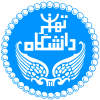

Amir Nemati

Stochastic process project - Summer 2024

load some libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
import statsmodels as sm


# Load Dataset

In [3]:
df = pd.read_csv("Tehran 2009-2019.csv",encoding='unicode_escape')
df.head()

,Year,Weather,Max,Min,Wind,Rain,Humidity,Cloud,Pressure
0,1/1/09,Partly cloudy,5 °c,-5 °c,4 km/hSSW,0.0 mm,62%,26%,1022 mb
1,1/2/09,Sunny,4 °c,0 °c,5 km/hS,3.4 mm,74%,32%,1014 mb
2,1/3/09,Sunny,4 °c,-3 °c,12 km/hW,0.0 mm,60%,6%,1016 mb
3,1/4/09,Sunny,3 °c,-7 °c,9 km/hWNW,0.0 mm,35%,1%,1022 mb
4,1/5/09,Sunny,4 °c,-7 °c,3 km/hW,0.0 mm,23%,14%,1023 mb


## Convert to time-series dataset

In [4]:
warnings.filterwarnings(action='ignore')
df.set_index('Year', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df1 =  df["Rain"]
def remove_mm(value):
    return float(value.replace(' mm', ''))
df1 = df1.apply(remove_mm)
df1 = pd.DataFrame(df1)
df1

,Rain
Year,
2009-01-01,0.0
2009-01-02,3.4
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
...,...
2020-11-10,0.0
2020-11-11,4.8
2020-11-12,2.8


# Part $1$
In the first section, we aim to calculate the Standardized Precipitation Index (SPI) both monthly and yearly. We use the paper by [**Lloyd-Hughes, B., & Saunders, M(A drought climatology for Europe. International Journal of Climatology,)**](https://doi.org/10.1002/joc.846)to define and calculate the SPI.
$$  SPI = \frac{x -\hat{\mu}}{\hat{\sigma}}$$

where $\hat{\mu}$ and $\hat{\sigma}$ are the sample estimates of the population mean and standard deviation respectively.

and we define Space State $\mathscr{S} = \{0,1\}$ 
and define:

$$
\text{State}(X_t) = 
\begin{cases} 
0 & \text{if } \text{SPI}(X_t) < 0 \\
1 & \text{if } \text{SPI}(X_t) \geq  0 
\end{cases}
$$

In [6]:
df1.index.name = 'Time'
df_monthly = df1.resample('M').sum()
df_monthly = df_monthly.rename(columns={'Rain': 'x'})
df_monthly["SPI"] = (df_monthly.x - np.mean(df_monthly.x) )/ np.std(df_monthly.x)
def State(x):
    if x < 0:
        State = 0
    else:
        State = 1
    return State
df_monthly["State"] = df_monthly.apply(lambda x: State(x["SPI"]), axis=1)
df_monthly

,x,SPI,State
Time,,,
2009-01-31,10.0,-0.457516,0
2009-02-28,9.9,-0.461767,0
2009-03-31,3.2,-0.746574,0
2009-04-30,33.1,0.524430,1
2009-05-31,13.8,-0.295984,0
...,...,...,...
2020-07-31,9.0,-0.500025,0
2020-08-31,7.0,-0.585042,0
2020-09-30,1.3,-0.827340,0


Now, to estimate the transition matrix, we need to determine the number of all combinations of 01, 00, 11, and 10.

In [7]:
warnings.filterwarnings(action='ignore')

N00,N01,N10,N11 = np.zeros(4)
for i in range(142):
    if df_monthly["State"][i+1] == 0:
        if df_monthly["State"][i] == 0:
            N00 +=1
        else:
            N10 += 1
    if df_monthly["State"][i+1] == 1:
        if df_monthly["State"][i] == 0:
            N01 += 1
        else:
            N11 += 1
P00 = N00/(N00+N01)
P11 = N11/(N10+N11)
P01 = 1 - P00
P10 = 1 - P11
P = np.matrix([[P00,P01],[P10,P11]])
P

matrix([[0.75280899, 0.24719101],
        [0.39622642, 0.60377358]])

$$ \hat{P} = \begin{bmatrix}
\hat{P}_{00} & \hat{P}_{01} \\
\hat{P}_{10} & \hat{P}_{11} 
\end{bmatrix}  $$

In [8]:

sequence = df_monthly["State"]
sequence = ''.join(map(str, sequence))
print(sequence)


00010100000000000001100000101100011000011110000000001000000000011101000001111000011110110100000110110000000011011000011011111000011111111000011


now for model selection we use two estimator AIC and BIC
where:
- $\mathrm{AIC}=2 k-2 \log (L)$
- $\mathrm{BIC}=k \log (N)-2 \log (L)$


Where $k$ is the number of parameters, $L$ is the likelihood of the model, and $N$ is the number of observations (sequence length).

$$ L(\hat{P}|X.) = \prod _{t=1}^NP(X_t|X_{t-1}=x_{t-1},\dots,X_{t-p}=x_{t-p})\pi_0 $$
where $X$ is MC of order($p$)

In [9]:
from collections import defaultdict
def count_transitions(sequence, n):
    transitions = defaultdict(lambda: defaultdict(int))
    for i in range(len(sequence) - n):
        current_state = sequence[i:i+n]
        next_state = sequence[i+1:i+n+1]
        transitions[current_state][next_state] += 1
    return transitions

def normalize_transitions(transitions, n):
    all_states = [''.join(format(i, '0' + str(n) + 'b')) for i in range(2**n)]
    transition_matrix = defaultdict(lambda: defaultdict(float))
    
    for state in all_states:
        if state in transitions:
            total = sum(transitions[state].values())
            for next_state, count in transitions[state].items():
                transition_matrix[state][next_state] = count / total
    
    return transition_matrix, all_states

def create_np_matrix(transition_matrix, all_states):
    matrix_size = len(all_states)
    matrix = np.zeros((matrix_size, matrix_size))
    
    state_to_index = {state: index for index, state in enumerate(all_states)}
    
    for state, next_states in transition_matrix.items():
        for next_state, prob in next_states.items():
            matrix[state_to_index[state]][state_to_index[next_state]] = prob
    
    return matrix

def print_transition_matrix_np(matrix, all_states):
    header = "    " + "  ".join(all_states)
    print(header)
    
    for i, row in enumerate(matrix.tolist()):
        print(f"{all_states[i]} " + " ".join(f"{prob:.2f}" for prob in row))


for n in range(1,5):
    transitions = count_transitions(sequence, n)
    transition_matrix, all_states = normalize_transitions(transitions, n)
    matrix = create_np_matrix(transition_matrix, all_states)
    print("P",n," = ")
    print_transition_matrix_np(matrix, all_states)
    print("_________________________")

def log_likelihood(sequence, transition_matrix, n):
    likelihood = 0
    for i in range(len(sequence) - n):
        current_state = sequence[i:i+n]
        next_state = sequence[i+1:i+n+1]
        if transition_matrix[current_state][next_state] > 0:
            likelihood += np.log(transition_matrix[current_state][next_state])
    return likelihood

def calculate_aic_bic(sequence, n):
    transitions = count_transitions(sequence, n)
    transition_matrix, all_states = normalize_transitions(transitions, n)
    matrix = create_np_matrix(transition_matrix, all_states)
    
    log_likelihood_val = log_likelihood(sequence, transition_matrix, n)
    num_parameters = len(all_states) ** 2
    num_observations = len(sequence) - n
    
    aic = 2 * num_parameters - 2 * log_likelihood_val
    bic = num_parameters * np.log(num_observations) - 2 * log_likelihood_val
    
    return aic, bic

def print_best_model(sequence, max_n=5):
    best_aic = float('inf')
    best_bic = float('inf')
    best_n_aic = None
    best_n_bic = None
    
    for n in range(1, max_n+1):
        aic, bic = calculate_aic_bic(sequence, n)
        print(f"Order {n}: AIC = {aic:.2f}, BIC = {bic:.2f}")
        
        if aic < best_aic:
            best_aic = aic
            best_n_aic = n
        
        if bic < best_bic:
            best_bic = bic
            best_n_bic = n
    
    print(f"\nBest model by AIC: Order {best_n_aic} with AIC = {best_aic:.2f}")
    print(f"Best model by BIC: Order {best_n_bic} with BIC = {best_bic:.2f}")

print_best_model(sequence, max_n=5)


P 1  = 
    0  1
0 0.75 0.25
1 0.40 0.60
_________________________
P 2  = 
    00  01  10  11
00 0.79 0.21 0.00 0.00
01 0.00 0.00 0.27 0.73
10 0.62 0.38 0.00 0.00
11 0.00 0.00 0.48 0.52
_________________________
P 3  = 
    000  001  010  011  100  101  110  111
000 0.74 0.26 0.00 0.00 0.00 0.00 0.00 0.00
001 0.00 0.00 0.21 0.79 0.00 0.00 0.00 0.00
010 0.00 0.00 0.00 0.00 0.67 0.33 0.00 0.00
011 0.00 0.00 0.00 0.00 0.00 0.00 0.60 0.40
100 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
101 0.00 0.00 0.38 0.62 0.00 0.00 0.00 0.00
110 0.00 0.00 0.00 0.00 0.60 0.40 0.00 0.00
111 0.00 0.00 0.00 0.00 0.00 0.00 0.38 0.62
_________________________
P 4  = 
    0000  0001  0010  0011  0100  0101  0110  0111  1000  1001  1010  1011  1100  1101  1110  1111
0000 0.69 0.31 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0001 0.00 0.00 0.21 0.79 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0010 0.00 0.00 0.00 0.00 0.33 0.67 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

**so best model is MC with order 1**

In [10]:
df_yearly = df1.resample('Y').sum()
df_yearly = df_yearly.rename(columns={'Rain': 'x'})
df_yearly["SPI"] = (df_yearly.x - np.mean(df_yearly.x) )/ np.std(df_yearly.x)
def State(x):
    if x < 0:
        State = 0
    else:
        State = 1
    return State
df_yearly["State"] = df_yearly.apply(lambda x: State(x["SPI"]), axis=1)
df_yearly


,x,SPI,State
Time,,,
2009-12-31,131.6,-0.836236,0
2010-12-31,125.7,-0.878833,0
2011-12-31,212.6,-0.251430,0
2012-12-31,242.5,-0.035558,0
2013-12-31,118.4,-0.931537,0
2014-12-31,184.2,-0.456473,0
2015-12-31,249.3,0.013537,1
2016-12-31,212.7,-0.250708,0
2017-12-31,167.9,-0.574156,0


In [11]:
sequence = df_yearly["State"]
sequence = ''.join(map(str, sequence))
print(sequence)

000000100111


In [12]:
for n in range(1,5):
    transitions = count_transitions(sequence, n)
    transition_matrix, all_states = normalize_transitions(transitions, n)
    matrix = create_np_matrix(transition_matrix, all_states)
    print("P",n," = ")
    print_transition_matrix_np(matrix, all_states)
    print("_________________________")
print_best_model(sequence, max_n=5)


P 1  = 
    0  1
0 0.75 0.25
1 0.33 0.67
_________________________
P 2  = 
    00  01  10  11
00 0.67 0.33 0.00 0.00
01 0.00 0.00 0.50 0.50
10 1.00 0.00 0.00 0.00
11 0.00 0.00 0.00 1.00
_________________________
P 3  = 
    000  001  010  011  100  101  110  111
000 0.75 0.25 0.00 0.00 0.00 0.00 0.00 0.00
001 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
010 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00
011 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
100 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
101 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
110 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
111 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
_________________________
P 4  = 
    0000  0001  0010  0011  0100  0101  0110  0111  1000  1001  1010  1011  1100  1101  1110  1111
0000 0.67 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0001 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0010 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

**so best model is MC with order 1**

# Part $2$
In this section, we aim to use continuous rain data to predict and model using a continuous Markov chain. A useful continuous Markov chain is the Autoregressive process, denoted by **AR($p$)**, where $p$ is the order of the process (any Autoregressive process of order $p$ is a Markov chain of order $p$.

We define **AR($p$)** as:
$$ X_t = c + \sum_{i=1}^p \phi_iX_{t-i}+\epsilon_t$$
where :
  - c is a constant.
  - $\phi_1,\phi_2,\dots,\phi_p$ are parameters.
  - $\epsilon_t$ is white noise (i.e., a sequence of uncorrelated Normal random variables with mean zero and constant variance($\sigma_\epsilon^2$))

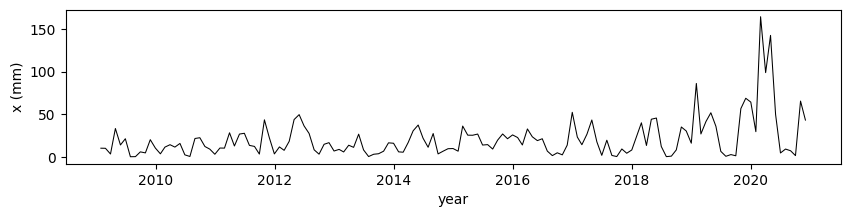

In [13]:
plt.figure(figsize=(10,2))
plt.plot(df_monthly.x,color ="black",linewidth = 0.75)
plt.xlabel("year"),plt.ylabel("x (mm)")
plt.show()

In [14]:
from statsmodels.tsa.ar_model import AutoReg , ar_select_order
max_lag = 6
result = ar_select_order(df_monthly.x, maxlag=max_lag, ic='aic', trend='c')

# Display AIC and BIC for each lag
print("AIC for each lag:")
print(result.aic)
min_aic = min(result.aic, key=lambda k: result.aic[k])
print(f"So the model with the lowest AIC is AR({min_aic[-1]})")
print("\n BIC for each lag:")
print(result.bic)
min_bic = min(result.bic, key=lambda k: result.bic[k])
print(f"So the model with the lowest BIC is AR({min_bic[-1]})")

AIC for each lag:
{(1, 2): 1217.9767843352708, (1, 2, 3): 1218.3482017648737, (1,): 1219.2587065703776, (1, 2, 3, 4): 1219.5475368892785, (1, 2, 3, 4, 5, 6): 1221.199933487116, (1, 2, 3, 4, 5): 1221.499933455026, 0: 1260.6607618629641}
So the model with the lowest AIC is AR(2)

 BIC for each lag:
{(1,): 1225.0986684220338, (1, 2): 1226.7367271127553, (1, 2, 3): 1230.028125468186, (1, 2, 3, 4): 1234.147441518419, (1, 2, 3, 4, 5): 1239.0198190099948, (1, 2, 3, 4, 5, 6): 1241.6397999679127, 0: 1263.5807427887923}
So the model with the lowest BIC is AR(1)


We choose the model by lowest BIC because BIC tends to simpler models.

so our model is **AR(1)**

In [15]:
model = AutoReg(df_monthly.x, lags=min_bic[-1])
model_fitted = model.fit()
model_fitted.params,model_fitted.sigma2



(const    10.167138
 x.L1      0.517879
 dtype: float64,
 407.9585160032712)

so our model is $$X_t = 10.16 + 0.517X_{t-1} + \epsilon_t $$ 

where $\epsilon \sim N(0,407.95)$

## b) Transition probability

Clearly, in the continuous case, we know that $P(X_t = x_t \mid X_{t-1} = x_{t-1}) = 0$ for all $x_t$, but we can calculate $P(X_t \in A \mid X_{t-1} = x_{t-1})$, where $A$ is a non-empty subset of $\mathbb{R}$.

For this calculation, we need to know the distribution of $X_t \mid X_{t-1}$.

**Theorem**: If $X$ is a normally distributed random variable with mean $\mu$ and variance $\sigma^2$, then any linear transformation of $X$, given by $Y = aX + b$ (where $a$ and $b$ are constants), is also normally distributed with mean $a\mu + b$ and variance $a^2\sigma^2$.

Given $X_t \mid X_{t-1} = x_{t-1}$, we have 

$$
X_t = \delta + x_{t-1} + \epsilon_t
$$

So, by the theorem, the distribution of $X_t \mid X_{t-1} = x_{t-1}$ is normal with mean $\delta + x_{t-1}$ and variance $\sigma_\epsilon^2$.

Therefore,

$$
X_t \mid X_{t-1} \sim N(\delta + X_{t-1}, \sigma_\epsilon^2)
$$

so we can calculate $P(X_t \in A \mid X_{t-1} = x_{t-1})$ for any set $A$ by $\int_A f_{X_t|X_{t-1}}(x)dx$

# Part $3$


In [17]:
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = "Tehran 2009-2019.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Year' to datetime format and rename to 'Date'
data['Date'] = pd.to_datetime(data['Year'], format='%m/%d/%y')
data = data.drop(columns=['Year'])

# Extract numerical values from temperature columns and convert to float
data['Max'] = data['Max'].str.replace(' °c', '').astype(float)
data['Min'] = data['Min'].str.replace(' °c', '').astype(float)

# Extract numerical values from 'Wind' and convert to float
data['Wind'] = data['Wind'].str.extract(r'(\d+)').astype(float)

# Extract numerical values from 'Rain', 'Humidity', 'Cloud', and 'Pressure' and convert to float
data['Rain'] = data['Rain'].str.replace(' mm', '').astype(float)
data['Humidity'] = data['Humidity'].str.replace('%', '').astype(float)
data['Cloud'] = data['Cloud'].str.replace('%', '').astype(float)
data['Pressure'] = data['Pressure'].str.replace(' mb', '').astype(float)
data['Mid'] = 0.5*(data["Max"] + data["Min"])
# Display the cleaned data

data = data[["Date","Rain","Mid","Humidity","Cloud","Wind"]]
data.head()

,Date,Rain,Mid,Humidity,Cloud,Wind
0,2009-01-01,0.0,0.0,62.0,26.0,4.0
1,2009-01-02,3.4,2.0,74.0,32.0,5.0
2,2009-01-03,0.0,0.5,60.0,6.0,12.0
3,2009-01-04,0.0,-2.0,35.0,1.0,9.0
4,2009-01-05,0.0,-1.5,23.0,14.0,3.0


In [18]:
data.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
data.head()

,Rain,Mid,Humidity,Cloud,Wind
Date,,,,,
2009-01-01,0.0,0.0,62.0,26.0,4.0
2009-01-02,3.4,2.0,74.0,32.0,5.0
2009-01-03,0.0,0.5,60.0,6.0,12.0
2009-01-04,0.0,-2.0,35.0,1.0,9.0
2009-01-05,0.0,-1.5,23.0,14.0,3.0


In [19]:
monthly_data = data.resample('M').agg({
    'Mid': 'mean',
    'Wind': 'mean',
    'Humidity': 'mean',
    'Cloud': 'mean',
    'Rain': 'sum'
})
data = monthly_data
data.head()

,Mid,Wind,Humidity,Cloud,Rain
Date,,,,,
2009-01-31,-0.258065,7.161290,55.580645,13.387097,10.0
2009-02-28,3.625000,9.392857,57.142857,15.714286,9.9
2009-03-31,8.064516,10.387097,37.322581,14.387097,3.2
2009-04-30,9.166667,8.666667,50.666667,13.833333,33.1
2009-05-31,18.161290,9.322581,35.064516,11.612903,13.8


## Continuous Hidden Markov Model (HMM)
### 1. HMM Components
A continuous HMM is characterized by:
-  **N** : The number of hidden states.
-  **M** : The number of observation symbols (for continuous HMM, observations are continuous values, so M is not used as in discrete HMMs).
-  **A** : The state transition probability matrix $ A = {a_{ij}}$, where $ a_{ij} = P(q_{t+1} = S_j \mid q_t = S_i) $
-  **B**: The observation probability density function (PDF) for each state $ B = \{b_j(o)\} $. In the Gaussian HMM, each state $ S_j $ has a mean vector $ \mu_j $ and a covariance matrix $ \Sigma_j $ such that $ b_j(o) \sim \mathcal{N}(\mu_j, \Sigma_j) $.
-  $\boldsymbol{\pi}$ : The initial state distribution vector $ \pi = \{\pi_i\} $, where $ \pi_i = P(q_1 = S_i) $.### 2. Model Definition

Given observations $ O = \{o_1, o_2, \ldots, o_T\} $:
- Hidden states: $ Q = \{q_1, q_2, \ldots, q_T\} $, where $ q_t $ is the hidden state at time $t$.

### 3. Training the HMM

Training involves estimating the parameters
$\lambda = (A,B,\pi)$ using the observed data. The typical algorithm used is the Expectation-Maximization (EM) algorithm, specifically the Baum-Welch algorithm for HMMs.
let $X = \{X_1 ,X_2,\dots,X_T\} $ be the matrix of observed features (Mid, Wind, Humidity, Cloud). Each $X_t$ is a vector of these features at time $t$.

- $X_t = (X_t^{(1)},X_t^{(2)},X_t^{(3)},X_t^{(4)})$

- Standardization: $\hat{X_t} = \frac{X_t -\mu}{\sigma}$

In [20]:
from sklearn.preprocessing import StandardScaler

# Define features for modeling
features = ['Mid', 'Wind', 'Humidity', 'Cloud']

# Extract features and target variable
X = data[features]
y = data['Rain']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the first few rows of the standardized features
pd.DataFrame(X_scaled, columns=features).head()


,Mid,Wind,Humidity,Cloud
0,-1.564372,-0.233412,1.537194,-0.027629
1,-1.170402,1.017307,1.654504,0.234502
2,-0.719974,1.574545,0.166155,0.085010
3,-0.608151,0.610302,1.168192,0.022634
4,0.304431,0.977920,-0.003408,-0.227472


- Initialize $\pi, A, \mu_j, \Sigma_j$
- Use the Baum-Welch algorithm to iteratively:
- E-step: Calculate the expected values of the hidden states given the current parameters.
- M-step: Maximize the expected log-likelihood to update $\pi, A, \mu_j, \Sigma_j$.
- Predict Hidden States and Map to Rain.


In [29]:
from hmmlearn import hmm
import numpy as np

# Define the HMM with a chosen number of hidden states
n_components = 40  # Adjust the number of components (hidden states) as needed overfitted model
model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=1000)

# Fit the model on the scaled feature data
model.fit(X_scaled)

# Predict the hidden states
hidden_states = model.predict(X_scaled)

# Display the predicted hidden states
print(hidden_states)


Fitting a model with 1919 free scalar parameters with only 572 data points will result in a degenerate solution.


[ 5 31  8 31 13 13 22 33 13 13  2  5 31 35 31 13 13 22 33 30  0  4 12  9
 26 26 20 27 13 22 33 30  0  4 12  9 17  5 29 27 13 22 33 30  0  4 12  9
 23 36 29 27 13 22 33 30  0  4 12  9 17  5 29 27 13 22 33 30  0  4 12  9
 17 20 20 27 13 33 30  0  4 12  9 26 20 36 29 37 13 22 33 30  0  4 12  9
 26 26 20 27 13 22 33 30  0  4 12  9 20 38 18 29 23  3 30  0  4 12 35  1
 16 16 16 16 22 10 34 22 33 14 25 19 19 19 21 21 22 10 34 11 32 39 15]


Mean Squared Error: 186.1540771431366
R-squared: 0.6636247806922289


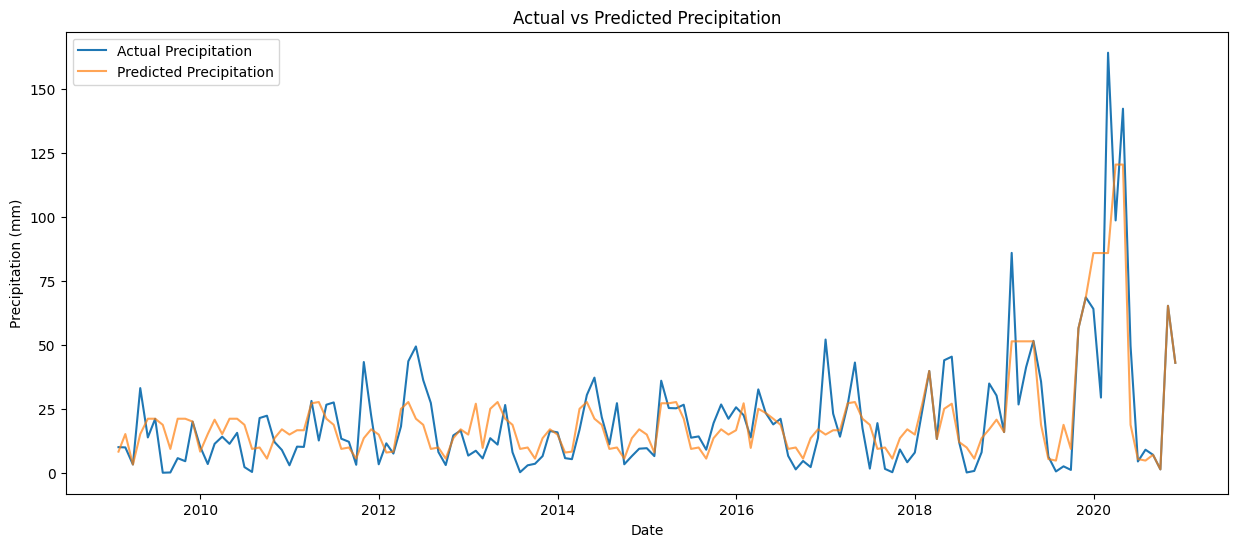

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# Add the hidden states to the dataframe
data['Hidden_State'] = hidden_states

# Group by hidden states and calculate the mean precipitation for each state
state_rain_means = data.groupby('Hidden_State')['Rain'].mean()

# Predict the precipitation based on the hidden states
predicted_rain = data['Hidden_State'].apply(lambda state: state_rain_means[state])

# Calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, predicted_rain)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y, predicted_rain)
print(f'R-squared: {r2}')

# Plot actual vs predicted precipitation
plt.figure(figsize=(15, 6))
plt.plot(data.index, y, label='Actual Precipitation')
plt.plot(data.index, predicted_rain, label='Predicted Precipitation', alpha=0.7)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Actual vs Predicted Precipitation')
plt.show()



Model is not converging.  Current: -353.8057872490225 is not greater than -311.2881813945898. Delta is -42.5176058544327
Model is not converging.  Current: -296.1296686073331 is not greater than -263.97561265719037. Delta is -32.15405595014272
Model is not converging.  Current: -341.974070363203 is not greater than -309.6786227895816. Delta is -32.2954475736214



Best HMM Configuration: {'n_components': 10, 'covariance_type': 'diag'}
R² Score: 0.454
Mean Squared Error: 302.300


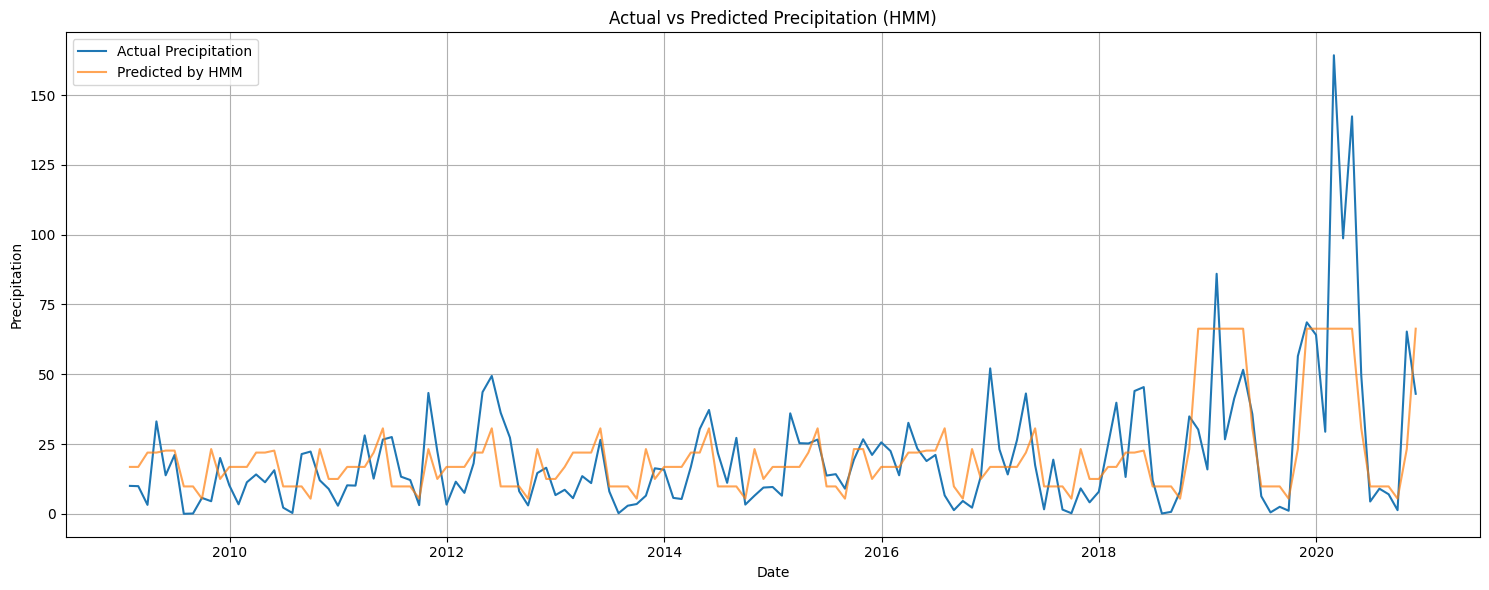

In [32]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_r2 = -np.inf
best_model = None
best_hidden_states = None
best_config = {}

for n_components in range(2, 11):
    for cov_type in ['diag', 'full']:
        try:
            model = hmm.GaussianHMM(n_components=n_components,
                                    covariance_type=cov_type,
                                    n_iter=1000,
                                    random_state=42)
            model.fit(X_scaled)
            hidden_states = model.predict(X_scaled)

            # میانگین بارش برای هر state
            data['Hidden_State'] = hidden_states
            state_rain_means = data.groupby('Hidden_State')['Rain'].mean()
            predicted_rain = data['Hidden_State'].map(state_rain_means)

            r2 = r2_score(y, predicted_rain)

            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_hidden_states = hidden_states.copy()
                best_config = {
                    'n_components': n_components,
                    'covariance_type': cov_type
                }

        except Exception as e:
            print(f"Error with {n_components=} {cov_type=}: {e}")

data['Hidden_State'] = best_hidden_states
state_rain_means = data.groupby('Hidden_State')['Rain'].mean()
predicted_rain = data['Hidden_State'].map(state_rain_means)

mse = mean_squared_error(y, predicted_rain)
r2 = r2_score(y, predicted_rain)

print(f"\nBest HMM Configuration: {best_config}")
print(f"R² Score: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")

plt.figure(figsize=(15, 6))
plt.plot(data.index, y, label='Actual Precipitation')
plt.plot(data.index, predicted_rain, label='Predicted by HMM', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Precipitation (HMM)')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.grid(True)
plt.tight_layout()
plt.show()
